Mounted at /content/drive


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors


📘 Eğitim Şiirleri:
➤ Maksimum uzunluk: 1530
➤ Minimum uzunluk: 2
➤ Ortalama uzunluk: 138.05887957317074

📙 Doğrulama Şiirleri:
➤ Maksimum uzunluk: 1149
➤ Minimum uzunluk: 2
➤ Ortalama uzunluk: 138.92577777777777


/tmp/ipython-input-2-2696103394.py:64: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2-2696103394.py:64: UserWarning: Glyph 128217 (\N{ORANGE BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128217 (\N{ORANGE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


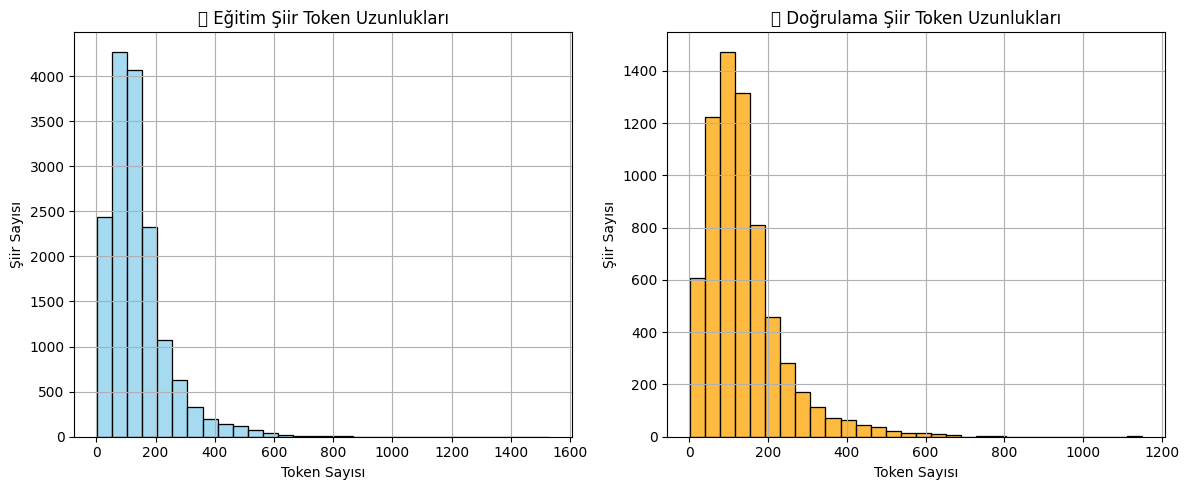

In [ ]:
# ✅ Google Drive'a bağlan
from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli kütüphaneler (Yüklü değilse çalıştırın)
!pip install -U transformers --quiet

# ✅ Gerekli importlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

# ✅ Model ve tokenizer
model_name = "dbmdz/bert-base-turkish-128k-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Eğitim ve doğrulama verilerini oku
import json
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path   = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df   = pd.DataFrame(val_data)

# ✅ Token uzunluklarını hesapla
train_lengths = [len(tokenizer(s)["input_ids"]) for s in train_df["islenmis_siir"]]
val_lengths   = [len(tokenizer(s)["input_ids"]) for s in val_df["islenmis_siir"]]

# ✅ Özet bilgi yazdır
print("📘 Eğitim Şiirleri:")
print("➤ Maksimum uzunluk:", max(train_lengths))
print("➤ Minimum uzunluk:", min(train_lengths))
print("➤ Ortalama uzunluk:", np.mean(train_lengths))

print("\n📙 Doğrulama Şiirleri:")
print("➤ Maksimum uzunluk:", max(val_lengths))
print("➤ Minimum uzunluk:", min(val_lengths))
print("➤ Ortalama uzunluk:", np.mean(val_lengths))

# ✅ Histogram çiz
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_lengths, bins=30, color="skyblue")
plt.title("📘 Eğitim Şiir Token Uzunlukları")
plt.xlabel("Token Sayısı")
plt.ylabel("Şiir Sayısı")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(val_lengths, bins=30, color="orange")
plt.title("📙 Doğrulama Şiir Token Uzunlukları")
plt.xlabel("Token Sayısı")
plt.ylabel("Şiir Sayısı")
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# ✅ Ortamı Ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Kurulumlar (ilk kez çalıştırıyorsan aktif et)
# !pip install -U transformers datasets scikit-learn matplotlib seaborn joblib --quiet

# ✅ Google Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer,
    TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_70_30_final_cleaned_son.json"
val_path   = "/content/drive/MyDrive/val_70_30_final_cleaned_son.json"
save_dir   = "/content/drive/MyDrive/deberta_grid_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket Kodlama
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Tokenize Fonksiyonu
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Hugging Face modelleri sadece şu üç kolonu bekler: input_ids, attention_mask, labels
train_ds = train_ds.remove_columns([col for col in train_ds.column_names if col not in ['input_ids', 'attention_mask', 'label']])
val_ds = val_ds.remove_columns([col for col in val_ds.column_names if col not in ['input_ids', 'attention_mask', 'label']])

collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Değerlendirme Metriği
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Hiperparametre kombinasyonları
learning_rates = [3e-5, 5e-5]
dropouts = [0.2, 0.3, 0.4]
weight_decays = [0.01, 0.1]

# ✅ En düşük loss'a göre en iyi modeli kaydet
best_loss = float("inf")
best_model_path = os.path.join(save_dir, "model_best")
os.makedirs(best_model_path, exist_ok=True)

grid_results = []
start_total = time.time()

for lr in learning_rates:
    for dropout in dropouts:
        for wd in weight_decays:
            print(f"\n🔧 Deneniyor → LR: {lr}, Dropout: {dropout}, Weight Decay: {wd}")
            temp_out = "/content/temp_grid_output"
            if os.path.exists(temp_out):
                shutil.rmtree(temp_out)
            os.makedirs(temp_out, exist_ok=True)

            # ✅ Model ve Config
            config = AutoConfig.from_pretrained(
                model_name,
                num_labels=len(label_encoder.classes_),
                hidden_dropout_prob=dropout,
                attention_probs_dropout_prob=0.1  # sabit
            )
            model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

            # ✅ Eğitim Argümanları
            training_args = TrainingArguments(
                output_dir=temp_out,
                eval_strategy="epoch",
                save_strategy="epoch",
                logging_strategy="epoch",
                learning_rate=lr,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=64,  # A100 için uygun
                num_train_epochs=50,
                weight_decay=wd,
                warmup_ratio=0.05,
                lr_scheduler_type="cosine",
                load_best_model_at_end=True,
                metric_for_best_model="eval_loss",
                save_total_limit=1,
                seed=42,
                dataloader_num_workers=2,
                dataloader_pin_memory=True,
                report_to=[]
            )


            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_ds,
                eval_dataset=val_ds,
                tokenizer=tokenizer,
                data_collator=collator,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
            )

            trainer.train()
            metrics = trainer.evaluate()
            val_loss = metrics["eval_loss"]
            print(f"📉 Eval Loss: {val_loss:.4f}")

            grid_results.append((lr, dropout, wd, val_loss))

            if val_loss < best_loss:
                best_loss = val_loss
                trainer.save_model(best_model_path)
                joblib.dump(label_encoder, os.path.join(best_model_path, "label_encoder.pkl"))
                print("✅ Yeni en düşük loss model Drive'a kaydedildi.")

end_total = time.time()
print(f"\n⏱️ Toplam Eğitim Süresi: {end_total - start_total:.2f} saniye")
print(f"🏆 En düşük eval_loss: {best_loss:.4f}")
print(f"📂 Model kayıt klasörü: {best_model_path}")

# ✅ Grid sonuçlarını CSV'ye kaydet
df_results = pd.DataFrame(grid_results, columns=["lr", "dropout", "weight_decay", "val_loss"])
df_results = df_results.sort_values(by="val_loss")
df_results.to_csv(os.path.join(save_dir, "grid_search_results.csv"), index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]


🔧 Deneniyor → LR: 3e-05, Dropout: 0.2, Weight Decay: 0.01


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-4127994350.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# ✅ Ortamı Ayarla
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ Google Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer,
    TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"

save_dir   = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiket Kodlama
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Hesaplama
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_list.append(specificity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(labels, probs, multi_class="ovo")
    }

# ✅ Sabit Hiperparametreler
learning_rate = 3e-5
dropout = 0.2
weight_decay = 0.1

# ✅ Model ve Config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

# ✅ Eğitim Argümanları
training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=50,
    weight_decay=weight_decay,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    report_to=[]
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ✅ Eğit
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()
val_loss = metrics["eval_loss"]
print(f"📉 Eval Loss: {val_loss:.4f}")

# ✅ Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")
print(f"⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4-293357815.py:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Specificity,F1,Auc
1,1.345300,0.810855,0.710815,0.706755,0.710815,0.927704,0.699184,0.916431
2,0.595000,0.518016,0.827407,0.836448,0.827407,0.956852,0.829511,0.964683
3,0.473300,0.499442,0.853630,0.856820,0.853630,0.963407,0.854670,0.972051
4,0.384700,0.465200,0.865185,0.874259,0.865185,0.966296,0.866438,0.976622
5,0.333200,0.527872,0.869926,0.880717,0.869926,0.967481,0.872816,0.977995
6,0.292700,0.450842,0.877778,0.880705,0.877778,0.969444,0.878496,0.981193
7,0.252600,0.469961,0.880444,0.890476,0.880444,0.970111,0.882655,0.981797
8,0.221200,0.438648,0.890370,0.891668,0.890370,0.972593,0.890906,0.983024
9,0.195100,0.479133,0.891259,0.893076,0.891259,0.972815,0.891663,0.982009
10,0.174600,0.546956,0.887111,0.889581,0.887111,0.971778,0.887007,0.981098


📉 Eval Loss: 0.4386
✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model
⏱️ Eğitim süresi: 2633.06 saniye


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-2152920239.py:134: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.417300,0.905529,0.651852,0.649175,0.651852,0.651852,0.912963,0.639039,0.889160
2,0.753600,0.662003,0.781778,0.792220,0.781778,0.781778,0.945444,0.777981,0.950824
3,0.536500,0.538469,0.833926,0.842033,0.833926,0.833926,0.958481,0.836308,0.965815
4,0.454300,0.524455,0.844889,0.847515,0.844889,0.844889,0.961222,0.845856,0.971441
5,0.399700,0.559483,0.851111,0.858488,0.851111,0.851111,0.962778,0.852844,0.973592
6,0.361000,0.437843,0.872296,0.873429,0.872296,0.872296,0.968074,0.872687,0.978854
7,0.324100,0.499330,0.871407,0.874317,0.871407,0.871407,0.967852,0.872355,0.978398
8,0.298600,0.458111,0.877630,0.879678,0.877630,0.877630,0.969407,0.877799,0.980949
9,0.274400,0.454513,0.876741,0.877452,0.876741,0.876741,0.969185,0.876452,0.980997



📊 Değerlendirme Metrikleri:
eval_loss   : 0.4378
eval_accuracy: 0.8723
eval_precision: 0.8734
eval_recall : 0.8723
eval_sensitivity: 0.8723
eval_specificity: 0.9681
eval_f1     : 0.8727
eval_auc    : 0.9789
eval_runtime: 31.1089
eval_samples_per_second: 216.9790
eval_steps_per_second: 13.5650
epoch       : 9.0000

⏱️ Eğitim süresi: 2408.91 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

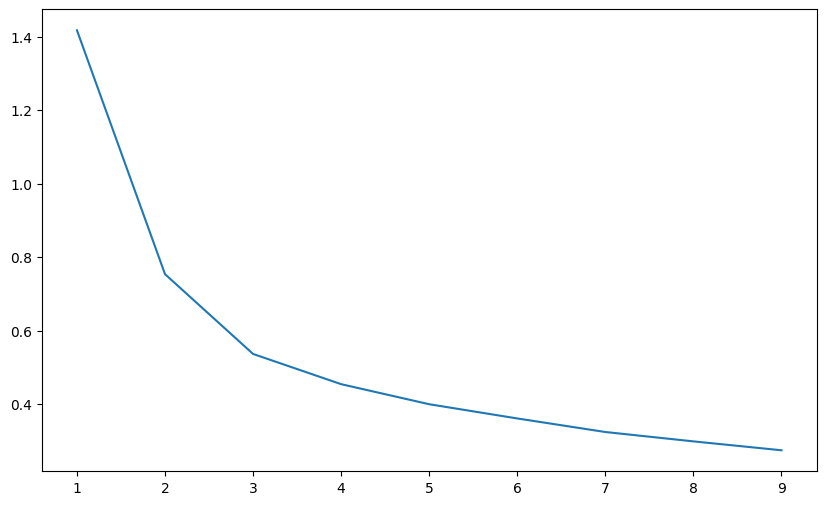

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    sensitivity_list = []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate = 2e-5
dropout = 0.3
weight_decay = 0.05

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=weight_decay,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği
log_history = trainer.state.log_history
epochs, train_loss, val_loss = [], [], []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss")
plt.plot(epochs[:len(val_loss)], val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-3478798038.py:131: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.496300,1.034257,0.606074,0.601164,0.606074,0.606074,0.901519,0.599687,0.855540
2,0.840400,0.799891,0.716000,0.725208,0.716000,0.716000,0.929000,0.699060,0.920605
3,0.629500,0.618240,0.814815,0.832710,0.814815,0.814815,0.953704,0.818560,0.958297
4,0.500300,0.596204,0.829926,0.840800,0.829926,0.829926,0.957481,0.832568,0.965810
5,0.451300,0.544037,0.841926,0.845775,0.841926,0.841926,0.960481,0.843386,0.970013
6,0.409500,0.518359,0.864889,0.867575,0.864889,0.864889,0.966222,0.865874,0.974363
7,0.358500,0.444851,0.872296,0.882083,0.872296,0.872296,0.968074,0.874644,0.979249
8,0.322000,0.435627,0.875407,0.876320,0.875407,0.875407,0.968852,0.875492,0.980461
9,0.301800,0.443183,0.880444,0.881894,0.880444,0.880444,0.970111,0.880950,0.979664
10,0.274000,0.446309,0.881037,0.883344,0.881037,0.881037,0.970259,0.881363,0.981177



📊 Değerlendirme Metrikleri:
eval_loss   : 0.4356
eval_accuracy: 0.8754
eval_precision: 0.8763
eval_recall : 0.8754
eval_sensitivity: 0.8754
eval_specificity: 0.9689
eval_f1     : 0.8755
eval_auc    : 0.9805
eval_runtime: 34.1620
eval_samples_per_second: 197.5880
eval_steps_per_second: 12.3530
epoch       : 11.0000

⏱️ Eğitim süresi: 3053.09 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


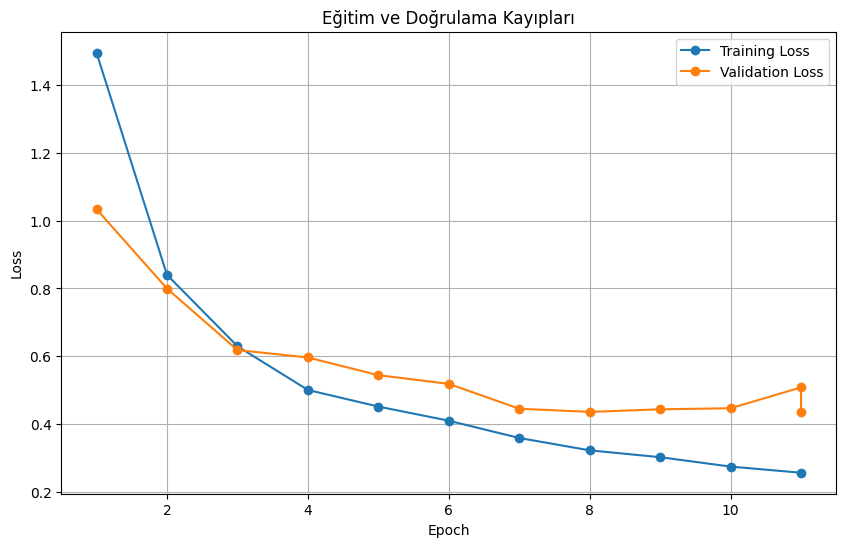

<Figure size 1000x800 with 0 Axes>

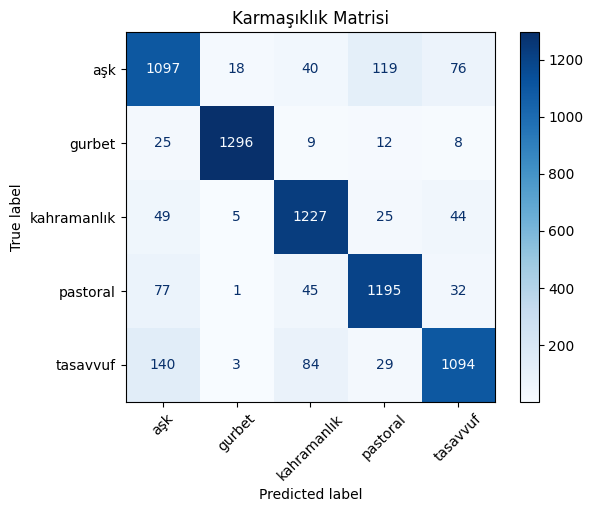

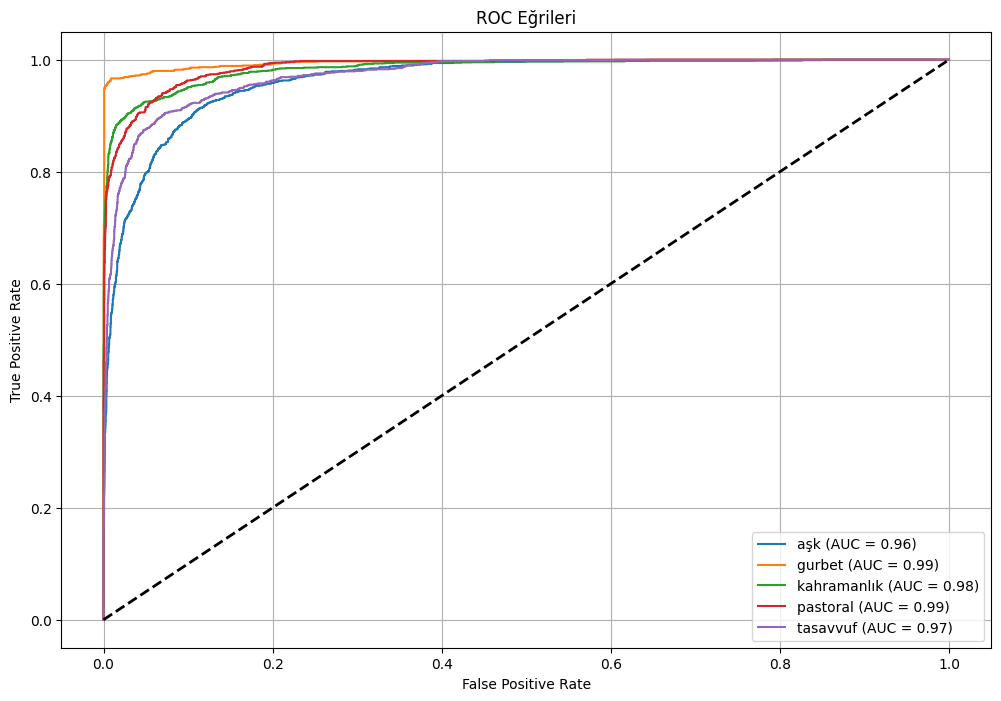

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    sensitivity_list = []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate = 2e-5
dropout = 0.3
weight_decay = 0.01

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=weight_decay,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği (Hatasız)
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-8-2109881648.py:128: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.605100,1.562482,0.284593,0.396948,0.284593,0.284593,0.821148,0.243604,0.665410
2,1.124300,0.800009,0.691111,0.698748,0.691111,0.691111,0.922778,0.680366,0.905976
3,0.751400,0.839295,0.726222,0.736774,0.726222,0.726222,0.931556,0.713420,0.925444
4,0.616100,0.599132,0.804000,0.808622,0.804000,0.804000,0.951000,0.805950,0.955992
5,0.512700,0.603799,0.824593,0.835408,0.824593,0.824593,0.956148,0.827645,0.963885
6,0.457000,0.521375,0.843852,0.850215,0.843852,0.843852,0.960963,0.845460,0.969176
7,0.405000,0.487428,0.856296,0.861652,0.856296,0.856296,0.964074,0.858092,0.973923
8,0.374400,0.503510,0.858222,0.861403,0.858222,0.858222,0.964556,0.858781,0.976024
9,0.344000,0.444599,0.873185,0.874926,0.873185,0.873185,0.968296,0.873526,0.979572
10,0.317800,0.415343,0.875407,0.880219,0.875407,0.875407,0.968852,0.876455,0.981326



📊 Değerlendirme Metrikleri:
eval_loss   : 0.4153
eval_accuracy: 0.8754
eval_precision: 0.8802
eval_recall : 0.8754
eval_sensitivity: 0.8754
eval_specificity: 0.9689
eval_f1     : 0.8765
eval_auc    : 0.9813
eval_runtime: 34.2048
eval_samples_per_second: 197.3410
eval_steps_per_second: 12.3370
epoch       : 13.0000

⏱️ Eğitim süresi: 3587.99 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


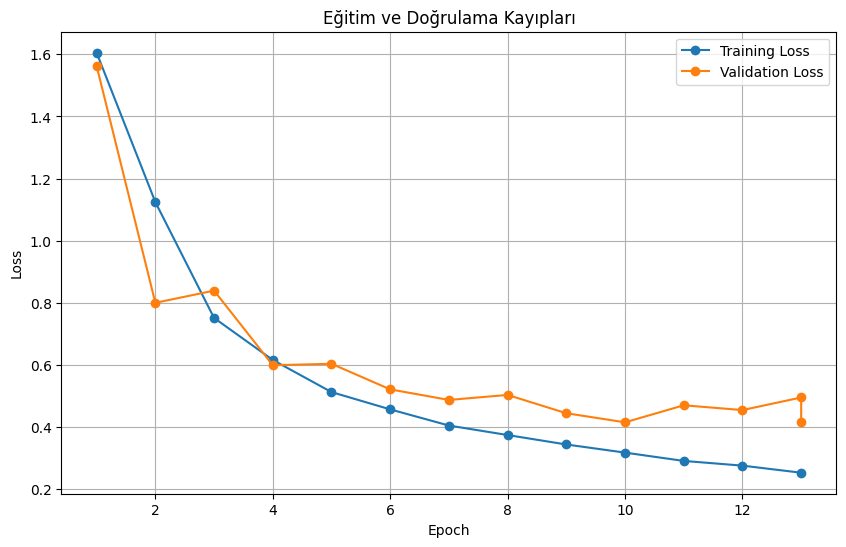

<Figure size 1000x800 with 0 Axes>

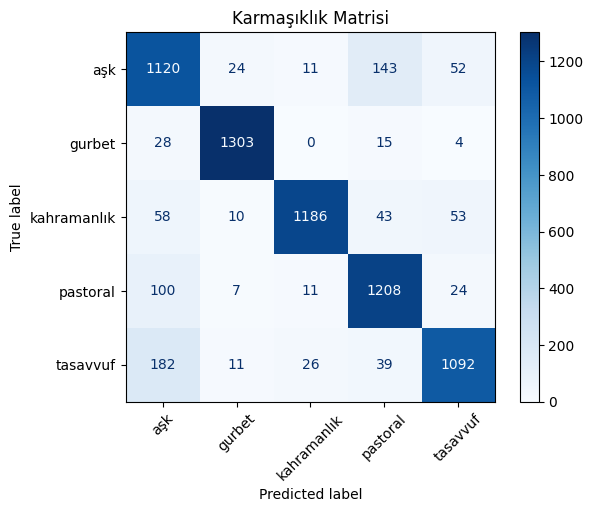

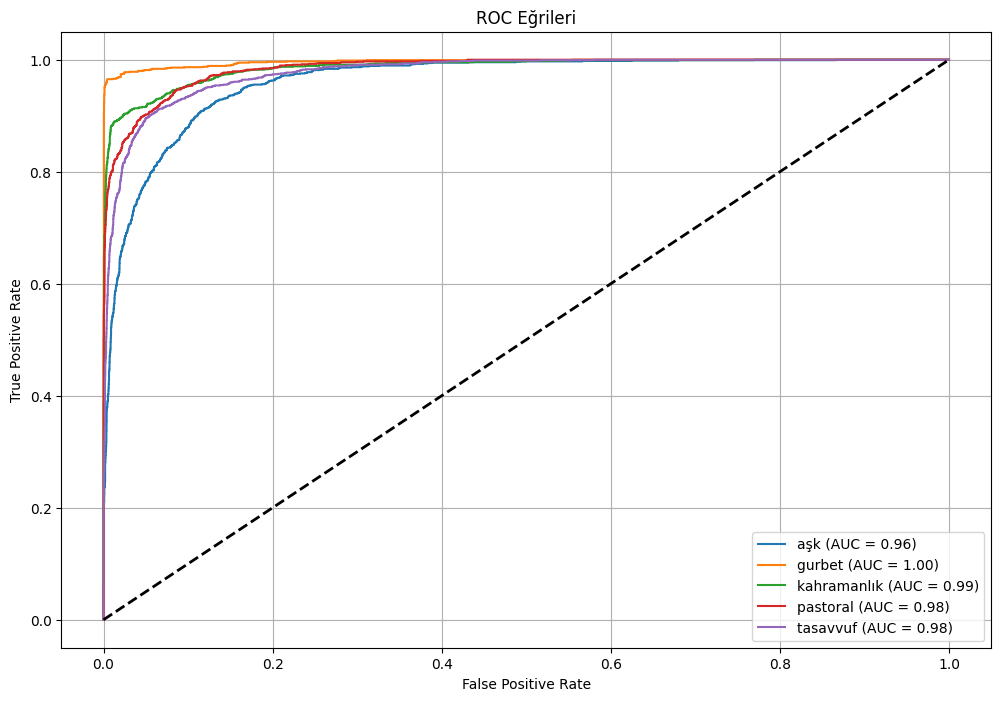

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list = []
    sensitivity_list = []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate = 1e-5

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği (Hatasız)
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-1995801670.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.616200,1.611302,0.200000,0.040000,0.200000,0.200000,0.800000,0.066667,0.527289
2,1.610400,1.594498,0.255704,0.200215,0.255704,0.255704,0.813926,0.155063,0.625766
3,1.590400,1.573465,0.280296,0.438274,0.280296,0.280296,0.820074,0.183934,0.676508
4,1.418900,1.176793,0.549926,0.614564,0.549926,0.549926,0.887481,0.520849,0.847905
5,1.108800,0.995198,0.674222,0.702235,0.674222,0.674222,0.918556,0.667982,0.901542
6,0.974900,0.925615,0.732593,0.733149,0.732593,0.732593,0.933148,0.731311,0.922902
7,0.906800,0.865307,0.769778,0.774824,0.769778,0.769778,0.942444,0.771451,0.940368
8,0.840200,0.836815,0.795852,0.802008,0.795852,0.795852,0.948963,0.798024,0.951298
9,0.797900,0.845102,0.796296,0.808854,0.796296,0.796296,0.949074,0.799556,0.952426
10,0.759400,0.807034,0.818963,0.825986,0.818963,0.818963,0.954741,0.821398,0.960224



📊 Değerlendirme Metrikleri:
eval_loss   : 0.7046
eval_accuracy: 0.8778
eval_precision: 0.8818
eval_recall : 0.8778
eval_sensitivity: 0.8778
eval_specificity: 0.9694
eval_f1     : 0.8789
eval_auc    : 0.9790
eval_runtime: 37.4987
eval_samples_per_second: 180.0060
eval_steps_per_second: 22.5070
epoch       : 30.0000

⏱️ Eğitim süresi: 8885.02 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


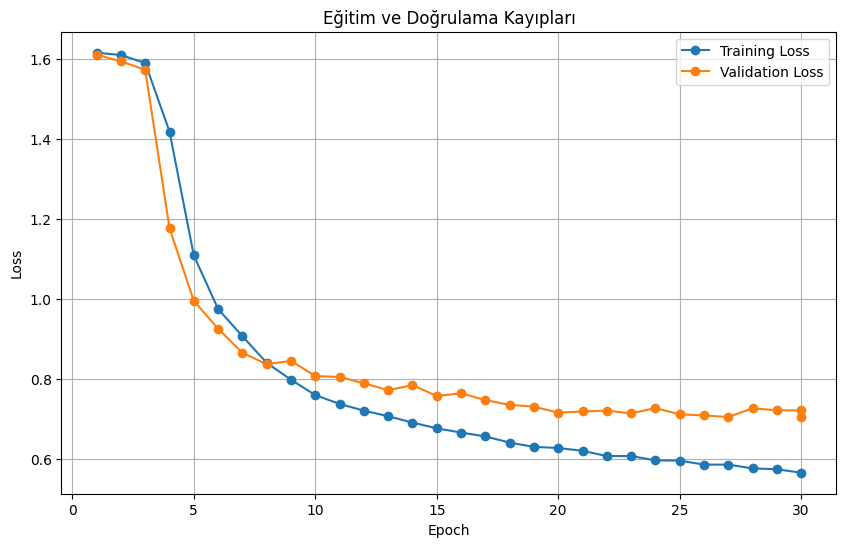

<Figure size 1000x800 with 0 Axes>

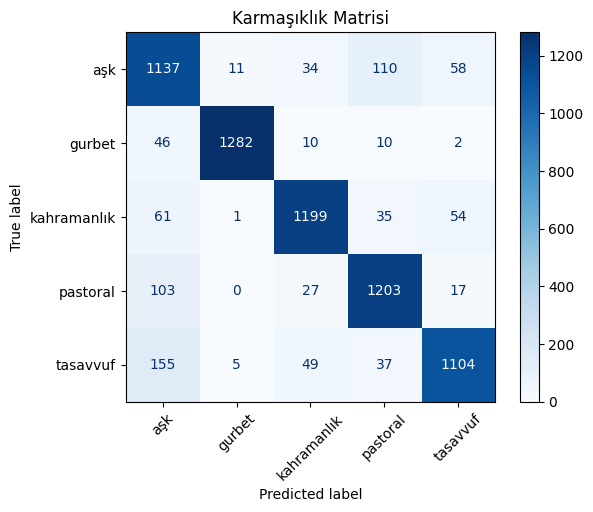

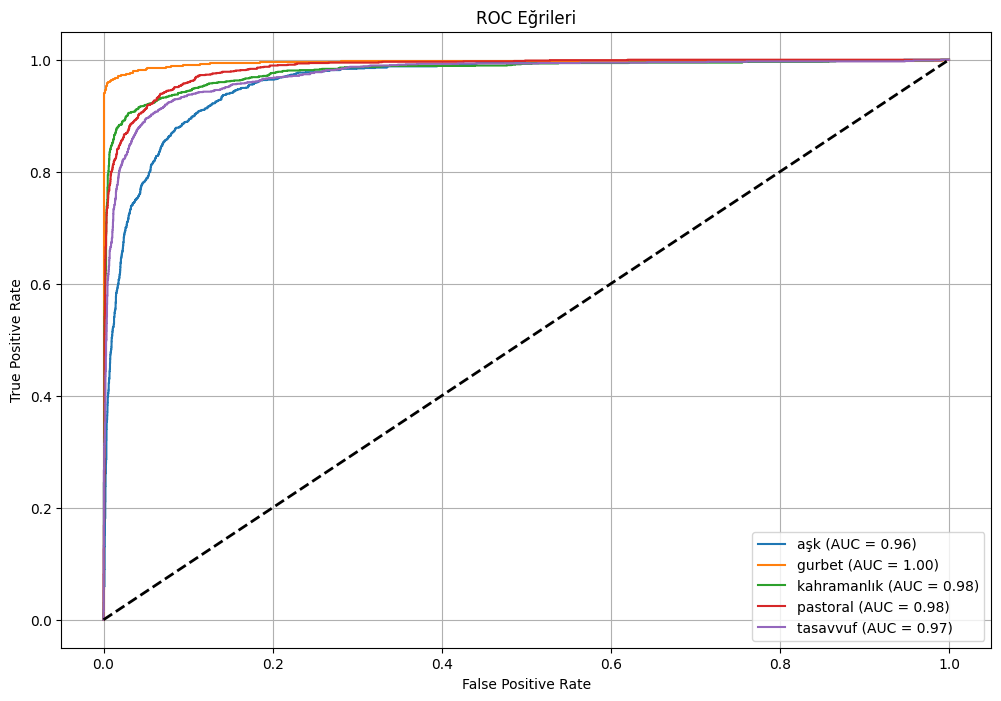

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list, sensitivity_list = [], []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate = 3e-6
dropout = 0.3
weight_decay = 0.1

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=weight_decay,
    label_smoothing_factor=0.1,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Mounted at /content/drive
🖥️ Kullanılan cihaz: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-1090659402.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.615300,1.611527,0.200000,0.040000,0.200000,0.200000,0.800000,0.066667,0.552983
2,1.610100,1.607372,0.226370,0.338569,0.226370,0.226370,0.806593,0.163439,0.546891
3,1.568700,1.564220,0.292741,0.434439,0.292741,0.292741,0.823185,0.239983,0.706217
4,1.349900,1.146118,0.567556,0.608514,0.567556,0.567556,0.891889,0.545196,0.854958
5,1.110300,0.993926,0.690074,0.702898,0.690074,0.690074,0.922519,0.688058,0.902585
6,0.985000,0.925026,0.742519,0.745630,0.742519,0.742519,0.935630,0.742154,0.925013
7,0.912200,0.889191,0.761037,0.782090,0.761037,0.761037,0.940259,0.761579,0.939802
8,0.861900,0.848904,0.789037,0.790812,0.789037,0.789037,0.947259,0.789239,0.949493
9,0.822200,0.827042,0.797630,0.803472,0.797630,0.797630,0.949407,0.799743,0.952339
10,0.792100,0.805983,0.810370,0.824631,0.810370,0.810370,0.952593,0.813463,0.958990


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.615300,1.611527,0.200000,0.040000,0.200000,0.200000,0.800000,0.066667,0.552983
2,1.610100,1.607372,0.226370,0.338569,0.226370,0.226370,0.806593,0.163439,0.546891
3,1.568700,1.564220,0.292741,0.434439,0.292741,0.292741,0.823185,0.239983,0.706217
4,1.349900,1.146118,0.567556,0.608514,0.567556,0.567556,0.891889,0.545196,0.854958
5,1.110300,0.993926,0.690074,0.702898,0.690074,0.690074,0.922519,0.688058,0.902585
6,0.985000,0.925026,0.742519,0.745630,0.742519,0.742519,0.935630,0.742154,0.925013
7,0.912200,0.889191,0.761037,0.782090,0.761037,0.761037,0.940259,0.761579,0.939802
8,0.861900,0.848904,0.789037,0.790812,0.789037,0.789037,0.947259,0.789239,0.949493
9,0.822200,0.827042,0.797630,0.803472,0.797630,0.797630,0.949407,0.799743,0.952339
10,0.792100,0.805983,0.810370,0.824631,0.810370,0.810370,0.952593,0.813463,0.958990



📊 Değerlendirme Metrikleri:
eval_loss   : 0.7864
eval_accuracy: 0.8244
eval_precision: 0.8315
eval_recall : 0.8244
eval_sensitivity: 0.8244
eval_specificity: 0.9561
eval_f1     : 0.8262
eval_auc    : 0.9623
eval_runtime: 37.3819
eval_samples_per_second: 180.5690
eval_steps_per_second: 22.5780
epoch       : 14.0000

⏱️ Eğitim süresi: 4127.57 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


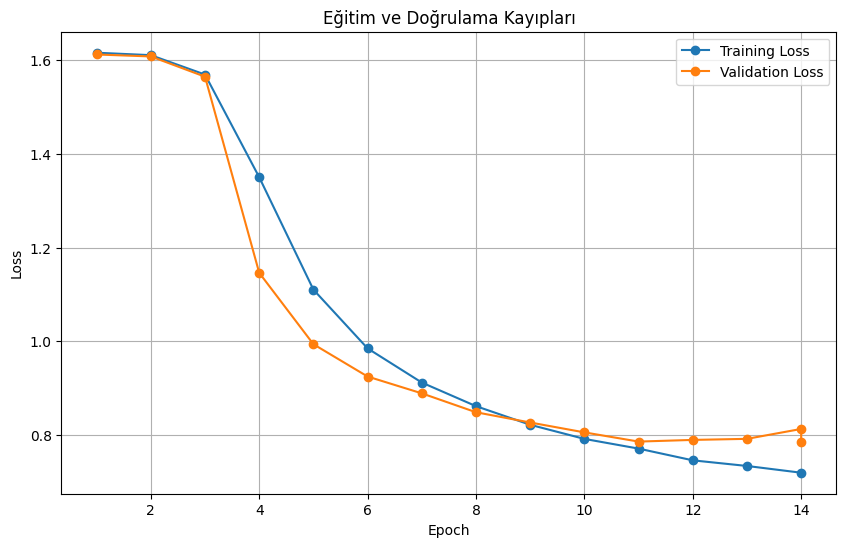

<Figure size 1000x800 with 0 Axes>

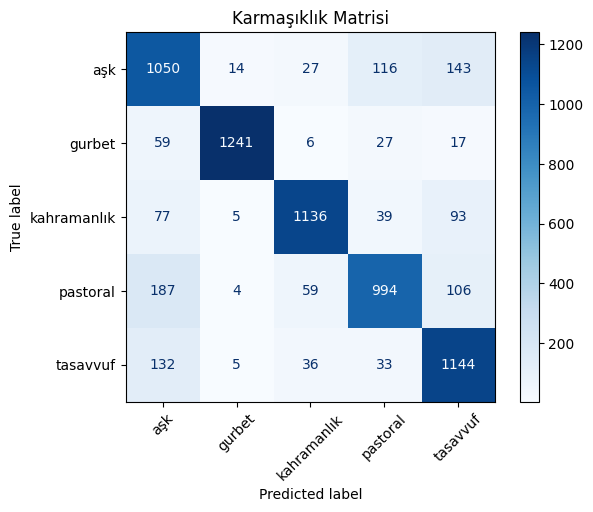

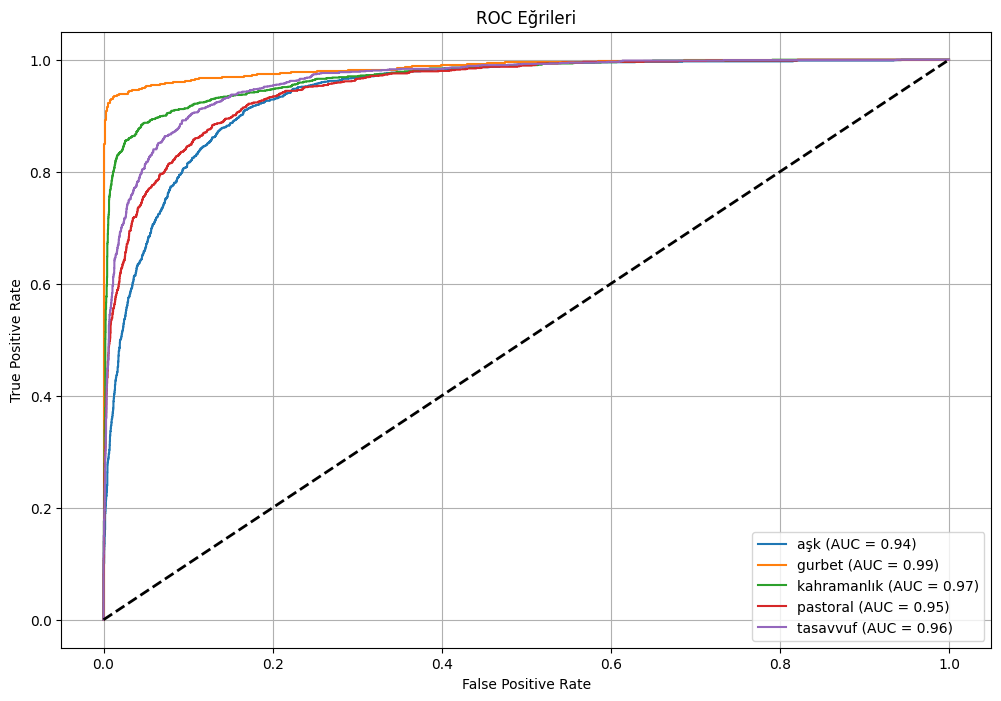

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list, sensitivity_list = [], []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate = 3e-6
dropout = 0.3
weight_decay = 0.2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.3
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=weight_decay,
    label_smoothing_factor=0.1,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🖥️ Kullanılan cihaz: cuda


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-2571730800.py:127: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.614400,1.608970,0.203259,0.143002,0.203259,0.203259,0.800815,0.077967,0.561690
2,1.601800,1.699288,0.202963,0.291620,0.202963,0.202963,0.800741,0.074456,0.652969
3,1.549600,1.507054,0.365037,0.496935,0.365037,0.365037,0.841259,0.309349,0.726603
4,1.141800,1.362036,0.529926,0.545568,0.529926,0.529926,0.882481,0.500793,0.827048
5,0.856700,0.839855,0.721185,0.727239,0.721185,0.721185,0.930296,0.723432,0.911844
6,0.746300,0.781614,0.754815,0.769970,0.754815,0.754815,0.938704,0.756510,0.930582
7,0.664500,0.846560,0.770370,0.805199,0.770370,0.770370,0.942593,0.774510,0.937645
8,0.606800,0.833468,0.784148,0.805082,0.784148,0.784148,0.946037,0.787180,0.940892
9,0.568200,0.824355,0.785630,0.795168,0.785630,0.785630,0.946407,0.787125,0.941647



📊 Değerlendirme Metrikleri:
eval_loss   : 0.7816
eval_accuracy: 0.7548
eval_precision: 0.7700
eval_recall : 0.7548
eval_sensitivity: 0.7548
eval_specificity: 0.9387
eval_f1     : 0.7565
eval_auc    : 0.9306
eval_runtime: 34.2589
eval_samples_per_second: 197.0290
eval_steps_per_second: 12.3180
epoch       : 9.0000

⏱️ Eğitim süresi: 2507.77 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


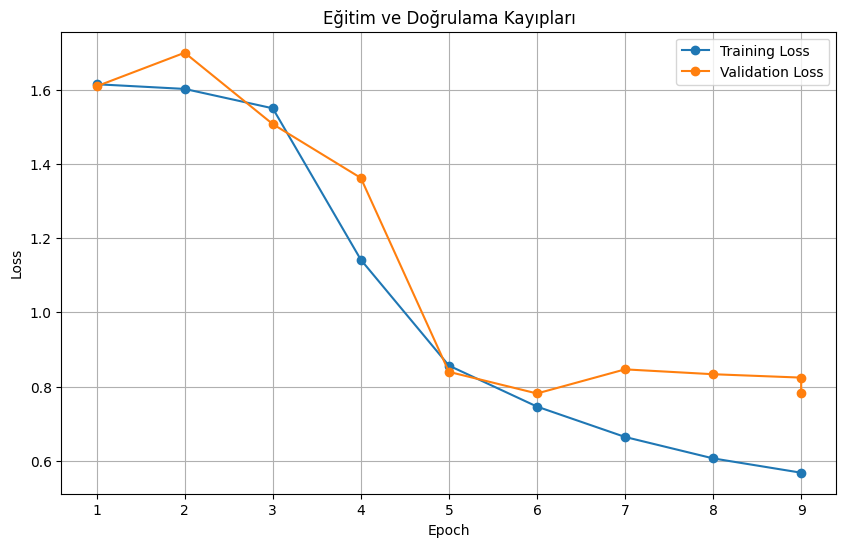

<Figure size 1000x800 with 0 Axes>

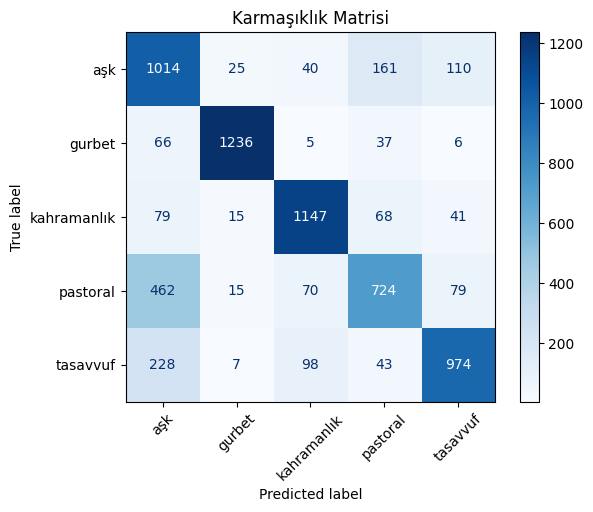

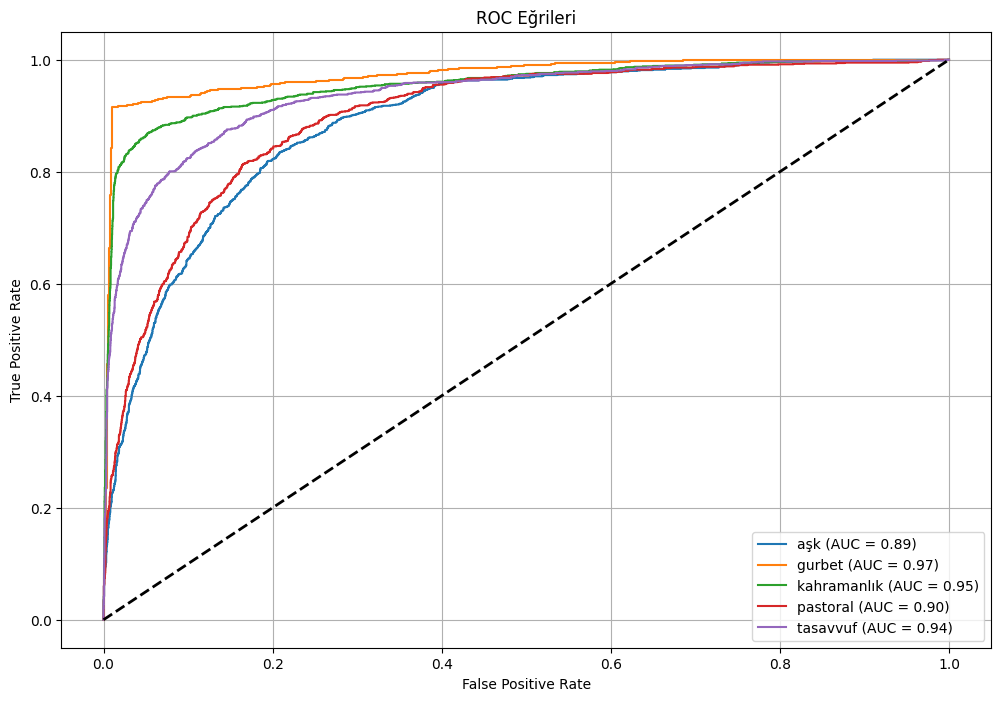

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list, sensitivity_list = [], []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate =7e-6
dropout = 0.4

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.4
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list, sensitivity_list = [], []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate =7e-6
dropout = 0.4

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.4
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_path,
    eval_strategy="epoch",  # Her epoch sonunda değerlendirme yap
    save_strategy="epoch",        # Her epoch sonunda checkpoint kaydet
    save_total_limit=1,           # Sadece en iyi modeli veya en son kaydedilen tek modeli tut (disk alanı için)
    load_best_model_at_end=True,  # Eğitim sonunda otomatik olarak en iyi modeli yükle
    metric_for_best_model="eval_loss", # En iyi modeli belirlemek için doğrulama kaybını kullan (düşük daha iyi)
    greater_is_better=False,      # eval_loss için daha düşük değer daha iyidir

    learning_rate=2e-6,           # LR'yi biraz daha düşürdük, daha kararlı öğrenme için
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2, # Etkin batch boyutunu 16 yapar (8 * 2). Daha stabil gradyanlar sağlar.
    num_train_epochs=50,          # Yüksek bir epoch sayısı, ancak EarlyStopping ile kontrol altında

    weight_decay=0.2,             # L2 düzenlileştirmeyi biraz artırdık (model ağırlıklarını küçültür)
    warmup_ratio=0.1,             # Başlangıçta öğrenme oranını yavaşça artırır (eğitim stabilitesi için)
    lr_scheduler_type="linear",   # Doğrusal öğrenme oranı azalması (common and effective)

    fp16=True,                    # Karışık hassasiyetli eğitim (GPU belleği ve hız için kritik)
    gradient_checkpointing=True,  # Büyük modeller için bellek kullanımını optimize eder

    logging_dir=os.path.join(save_path, "logs"), # Log dosyalarının kaydedileceği dizin
    logging_strategy="epoch",     # Her epoch sonunda logla
    report_to=["none"]            # İsteğe bağlı: None olarak ayarlandı, Hugging Face Hub'a raporlama yapmaz
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
import json
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"

# --- 1. Türkçe Eşanlamlılar Sözlüğü ---
# Bu sözlüğü ihtiyaçlarınıza göre genişletebilirsiniz.
synonym_dict = defaultdict(list)
synonym_dict.update({
    "aşk": ["sevgi", "sevda", "tutku", "aşık", "muhabbet"],
    "yürek": ["kalp", "gönül", "yürek"],
    "gurbet": ["hasret", "özlem", "uzak", "sıla", "dışarısı"],
    "vatan": ["yurt", "memleket", "toprak"],
    "kahraman": ["yiğit", "alp", "cesur", "kahramanlık"],
    "ömür": ["yaşam", "hayat", "ömür"],
    "çile": ["eziyet", "acı", "ızdırap", "dert"],
    "göz": ["nazar", "bakar", "gözler"],
    "yolcu": ["yolcu", "gezgin", "seyyah"],
    "tümsek": ["tepe", "yükseklik"],
    "zulüm": ["acımasızlık", "işkence"],
    "hasret": ["özlem", "gurbet"],
    "dağ": ["cebel", "sıradağ"],
    "acı": ["ızdırap", "çile"],
    "dünya": ["alem", "cihan", "evren"],
    "insan": ["kişi", "birey", "beşer"],
    "dost": ["arkadaş", "yoldaş", "ahbap"],
    "kader": ["yazgı", "talih"],
    "sessiz": ["sakin", "dingin", "suspus"],
    "ırmak": ["nehir", "akarsu"],
    "deniz": ["derya", "umman"],
    "gül": ["çiçek", "gonca"],
    "bülbül": ["şakrak", "kanarya"],
    "hürriyet": ["özgürlük", "bağımsızlık"],
    "savaş": ["harp", "muharebe", "çatışma"],
    "zafer": ["galibiyet", "yenme"],
    "şair": ["ozan", "dizeler", "şiirci"],
    "şiir": ["koşuk", "manzume"],
    "mübarek": ["kutlu", "uğurlu"],
    "toprak": ["arazi", "yer"],
    "kan": ["dem", "doku"],
    "can": ["ruh", "hayat"],
    "yıl": ["sene"],
    "gün": ["gündüz"],
    "gece": ["leyl"],
    "ışık": ["nur", "aydınlık"],
    "zaman": ["vakit", "çağ", "devir"],
    "kalp": ["yürek", "gönül", "çehre"],
    "umut": ["beklenti", "hayal"],
    "düşman": ["hasım", "rakip"],
    "cennet": ["uçmak", "adan"],
    "cehennem": ["tamuy"],
    "su": ["ab"],
    "ateş": ["od", "nar"],
    "güneş": ["gün", "hürşit"],
    "ay": ["kamer"],
    "yıldız": ["ahter"],
    "rüzgar": ["yel", "bad"],
    "ağaç": ["dar", "nebat"],
    "yaprak": ["varak"],
    "neşe": ["sevinç", "coşku"],
    "keder": ["üzüntü", "gam"],
    "hayal": ["düş", "hülya"],
    "bilgi": ["ilim", "malumat"],
    "okul": ["mektep"],
    "öğretmen": ["hoca", "muallim"],
    "öğrenci": ["talebe", "şakirt"],
    "ders": ["konu", "etüt"],
    "kitap": ["eser", "yazma"],
    "yazmak": ["kaleme almak", "tashih etmek"],
    "okumak": ["mütalaa etmek"],
    "konuşmak": ["söylemek", "demek"],
    "dinlemek": ["kulak vermek"],
    "görmek": ["bakmak", "seyretmek"],
    "duymak": ["işitmek"],
    "yemek": ["aş", "gıda"],
    "içmek": ["nûş etmek"],
    "uyumak": ["horlamak", "uykuya dalmak"],
    "uyanmak": ["gözünü açmak"],
    "gitmek": ["varmak", "seyahat etmek"],
    "gelmek": ["ulaşmak", "teşrif etmek"],
    "koşmak": ["sprint atmak", "hızla gitmek"],
    "yürümek": ["adımlamak", "gezmek"],
    "oturmak": ["ikamet etmek", "çökmek"],
    "kalkmak": ["ayağa kalkmak"],
    "sevmek": ["aşık olmak", "beğenmek"],
    "nefret": ["kin", "düşmanlık"],
    "mutlu": ["mesut", "şen"],
    "üzgün": ["kederli", "mahzun"],
    "büyük": ["iri", "ulu"],
    "küçük": ["ufak", "minik"],
    "iyi": ["güzel", "hoş"],
    "kötü": ["fena", "çirkin"],
    "doğru": ["hakikat", "gerçek"],
    "yanlış": ["hatalı", "eksik"],
    "sıcak": ["hararetli"],
    "soğuk": ["buz gibi", "serin"],
    "hızlı": ["çabuk", "süratli"],
    "yavaş": ["ağır", "sürüncemeli"],
    "açık": ["vazıh", "aydınlık"],
    "kapalı": ["örtülü", "mahcup"],
    "yeni": ["cedit", "taze"],
    "eski": ["köhne", "antik"],
    "bol": ["çok", "fazla"],
    "az": ["kıt", "eksik"],
    "temiz": ["pak", "saf"],
    "kirli": ["pis", "pasaklı"],
    "zor": ["güç", "çetin"],
    "kolay": ["basit", "rahat"],
    "yüksek": ["ali", "yüce"],
    "alçak": ["pes", "bayağı"],
    "güzel": ["cemil", "hüsnü"],
    "çirkin": ["nahoş", "mekruh"],
    "sessiz": ["sakin", "dingin"],
    "gürültülü": ["patırtılı", "cızırtılı"],
    "aydınlık": ["ışıklı", "parlak"],
    "karanlık": ["zulmetli", "siyah"]
})


# --- 2. Veri Artırma Fonksiyonları (EDA) ---

def get_synonyms(word, synonym_dict):
    """Bir kelimenin eşanlamlılarını döndürür."""
    return synonym_dict.get(word, [word])

def synonym_replacement(words, n):
    """
    Kelimelerin n kadarını eşanlamlılarıyla değiştirir.
    words: Liste halinde kelimeler.
    n: Kaç kelimenin değiştirileceği.
    """
    new_words = list(words)
    random_word_list = list(set([word for word in words if get_synonyms(word, synonym_dict)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word, synonym_dict)
        if len(synonyms) > 1:
            synonym = random.choice(list(set(synonyms) - set([random_word])))
            # Kelimenin birden fazla geçtiği durumlarda tüm örneklerini değiştirmek yerine ilkini değiştiririz.
            # Daha sofistike bir yaklaşım için tüm geçişleri bulup değiştirmek gerekebilir.
            if random_word in new_words:
                idx = new_words.index(random_word)
                new_words[idx] = synonym
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def random_insertion(words, n):
    """
    Rastgele seçilen n tane kelimenin eşanlamlılarını rastgele yerlere ekler.
    """
    new_words = list(words)
    for _ in range(n):
        word_to_insert = random.choice(words)
        synonyms = get_synonyms(word_to_insert, synonym_dict)
        if synonyms: # Eşanlamlı varsa
            new_word = random.choice(synonyms)
            new_words.insert(random.randint(0, len(new_words)), new_word)
    return ' '.join(new_words)

def random_swap(words, n):
    """
    n kez rastgele iki kelimenin yerini değiştirir.
    """
    new_words = list(words)
    if len(new_words) < 2: # Takas için en az 2 kelime olmalı
        return ' '.join(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return ' '.join(new_words)

def random_deletion(words, p):
    """
    Kelimelerin p olasılıkla silinmesini sağlar.
    """
    if len(words) == 1:
        return ' '.join(words)
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words) # Tüm kelimeler silinirse, orijinalden rastgele birini bırak
    return ' '.join(new_words)

def augment_text(text, num_aug=1):
    """
    Bir metni çeşitli EDA teknikleriyle artırır.
    num_aug: Her orijinal metinden kaç artırılmış örnek oluşturulacağı.
    """
    words = text.split()
    augmented_texts = []
    if not words: # Boş metinler için koruma
        return [""] * num_aug

    for _ in range(num_aug):
        aug_text_list = list(words) # Kopyasını al

        choice = random.randint(0, 3)
        if choice == 0: # Eşanlamlı kelime değiştirme
            aug_text_list = synonym_replacement(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 1: # Rastgele ekleme
            aug_text_list = random_insertion(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 2: # Rastgele takas
            aug_text_list = random_swap(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 3: # Rastgele silme
            aug_text_list = random_deletion(aug_text_list, 0.1)

        augmented_texts.append(aug_text_list) # Zaten string olarak döndürüyor

    return augmented_texts


# --- 3. Veri Okuma ve Birleştirme ---

print("Veri setleri okunuyor...")
try:
    with open(train_path, 'r', encoding='utf-8') as f:
        train_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
    with open(val_path, 'r', encoding='utf-8') as f:
        val_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
except FileNotFoundError:
    print(f"Hata: Dosya bulunamadı. Lütfen '{train_path}' ve '{val_path}' yollarını kontrol edin.")
    # Colab kullanıyorsanız, drive'ı bağladığınızdan emin olun:
    # from google.colab import drive
    # drive.mount('/content/drive')
    exit()
except json.JSONDecodeError as e:
    print(f"JSON Decode Hatası: {e}")
    print("Lütfen JSON dosyanızın geçerli bir formatta olduğundan emin olun.")
    exit()


df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)

# Toplam veri setini oluşturalım, böylece yeniden bölebiliriz.
# Eğer test setiniz tamamen ayrı ve hiç değişmeyecekse, bu birleştirmeyi yapmayıp sadece train_data'yı artırıp sonra bölmeniz gerekir.
# Ancak genel yaklaşım, train ve val'ı birleştirip artırma yapıp sonra yeniden bölmektir.
df_combined = pd.concat([df_train, df_val], ignore_index=True)
print(f"Toplam orijinal veri boyutu: {len(df_combined)} örnek.")

# --- 4. Veri Artırma Uygulaması ---

print("Eğitim verisi artırılıyor...")
augmented_records = []
# Her orijinal şiir için 1 artırılmış örnek oluşturacağız. (num_aug=1)
# Eğer daha fazla artırma istiyorsanız, num_aug değerini artırabilirsiniz (örn. num_aug=2).
# Bu durumda veri setiniz (orijinal + num_aug * orijinal) boyutunda olur.
# Mevcut haliyle, her şiirden 1 artırılmış kopya oluşturulup orijinalle birleştirilecektir.
for index, row in df_combined.iterrows():
    original_siir = row['islenmis_siir']
    augmented_siirs = augment_text(original_siir, num_aug=1) # Her orijinal için 1 yeni örnek
    for aug_siir in augmented_siirs:
        augmented_records.append({
            "baslik": row["baslik"],
            "siir": row["siir"],
            "konu": row["konu"],
            "islenmis_siir": aug_siir
        })

df_augmented = pd.DataFrame(augmented_records)

# Orijinal veriyi ve artırılmış veriyi birleştir
df_final_augmented = pd.concat([df_combined, df_augmented], ignore_index=True)
print(f"Veri artırma sonrası toplam veri boyutu: {len(df_final_augmented)} örnek.")

# --- 5. Veri Bölme ve Kaydetme ---

output_dir = "/content/drive/MyDrive/"

def save_dataframes_to_jsonl(df_train_part, df_val_part, train_filename, val_filename):
    """DataFrame'leri JSONL formatında kaydeder."""
    train_output_path = f"{output_dir}{train_filename}"
    val_output_path = f"{output_dir}{val_filename}"

    # Save as JSON (list of objects) instead of JSONL (line-delimited JSON)
    with open(train_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_train_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    with open(val_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_val_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    print(f"Dosyalar kaydedildi: {train_output_path} ve {val_output_path}")


# 5.1. %70 Eğitim / %30 Doğrulama Ayrımı
print("\n%70 Eğitim / %30 Doğrulama ayrımı yapılıyor...")
train_70, val_30 = train_test_split(
    df_final_augmented,
    test_size=0.3,
    stratify=df_final_augmented['konu'], # Konu dağılımını koru
    random_state=42
)
print(f"70/30 Eğitim Boyutu: {len(train_70)}, Doğrulama Boyutu: {len(val_30)}")
save_dataframes_to_jsonl(train_70, val_30, "augmented_train_70_30.json", "augmented_val_70_30.json")

# 5.2. %80 Eğitim / %20 Doğrulama Ayrımı
print("\n%80 Eğitim / %20 Doğrulama ayrımı yapılıyor...")
train_80, val_20 = train_test_split(
    df_final_augmented,
    test_size=0.2,
    stratify=df_final_augmented['konu'], # Konu dağılımını koru
    random_state=42
)
print(f"80/20 Eğitim Boyutu: {len(train_80)}, Doğrulama Boyutu: {len(val_20)}")
save_dataframes_to_jsonl(train_80, val_20, "augmented_train_80_20.json", "augmented_val_80_20.json")

print("\nVeri artırma ve bölme işlemleri tamamlandı.")
print("Şimdi bu yeni JSON dosyalarını (örneğin augmented_train_80_20.json) eğitim kodunuzda kullanabilirsiniz.")

Mounted at /content/drive
🖥️ Kullanılan cihaz: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

/tmp/ipython-input-1-54378068.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.617800,1.612304,0.200044,0.040009,0.200000,0.200000,0.800000,0.066679,0.510933
2,1.606200,1.569444,0.273950,0.445111,0.273905,0.273905,0.818481,0.197008,0.681323
3,1.260200,1.038296,0.654034,0.689012,0.653995,0.653995,0.913507,0.654804,0.891777
4,0.990800,0.894035,0.752278,0.764009,0.752272,0.752272,0.938070,0.756579,0.931522
5,0.887100,0.834056,0.789064,0.792885,0.789052,0.789052,0.947266,0.789788,0.949987
6,0.824700,0.807858,0.809513,0.817343,0.809500,0.809500,0.952378,0.811251,0.959326
7,0.779600,0.779530,0.834297,0.844910,0.834295,0.834295,0.958575,0.836958,0.967129
8,0.738100,0.760693,0.841965,0.850577,0.841964,0.841964,0.960492,0.844509,0.969306
9,0.708600,0.757330,0.846188,0.849609,0.846179,0.846179,0.961547,0.846776,0.970719
10,0.687100,0.726661,0.855968,0.863610,0.855954,0.855954,0.963991,0.857214,0.974234


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.617800,1.612304,0.200044,0.040009,0.200000,0.200000,0.800000,0.066679,0.510933
2,1.606200,1.569444,0.273950,0.445111,0.273905,0.273905,0.818481,0.197008,0.681323
3,1.260200,1.038296,0.654034,0.689012,0.653995,0.653995,0.913507,0.654804,0.891777
4,0.990800,0.894035,0.752278,0.764009,0.752272,0.752272,0.938070,0.756579,0.931522
5,0.887100,0.834056,0.789064,0.792885,0.789052,0.789052,0.947266,0.789788,0.949987
6,0.824700,0.807858,0.809513,0.817343,0.809500,0.809500,0.952378,0.811251,0.959326
7,0.779600,0.779530,0.834297,0.844910,0.834295,0.834295,0.958575,0.836958,0.967129
8,0.738100,0.760693,0.841965,0.850577,0.841964,0.841964,0.960492,0.844509,0.969306
9,0.708600,0.757330,0.846188,0.849609,0.846179,0.846179,0.961547,0.846776,0.970719
10,0.687100,0.726661,0.855968,0.863610,0.855954,0.855954,0.963991,0.857214,0.974234



📊 Değerlendirme Metrikleri:
eval_loss   : 0.6631
eval_accuracy: 0.8895
eval_precision: 0.8942
eval_recall : 0.8895
eval_sensitivity: 0.8895
eval_specificity: 0.9724
eval_f1     : 0.8905
eval_auc    : 0.9829
eval_runtime: 49.2845
eval_samples_per_second: 182.5730
eval_steps_per_second: 22.8270
epoch       : 17.0000

⏱️ Eğitim süresi: 10623.54 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


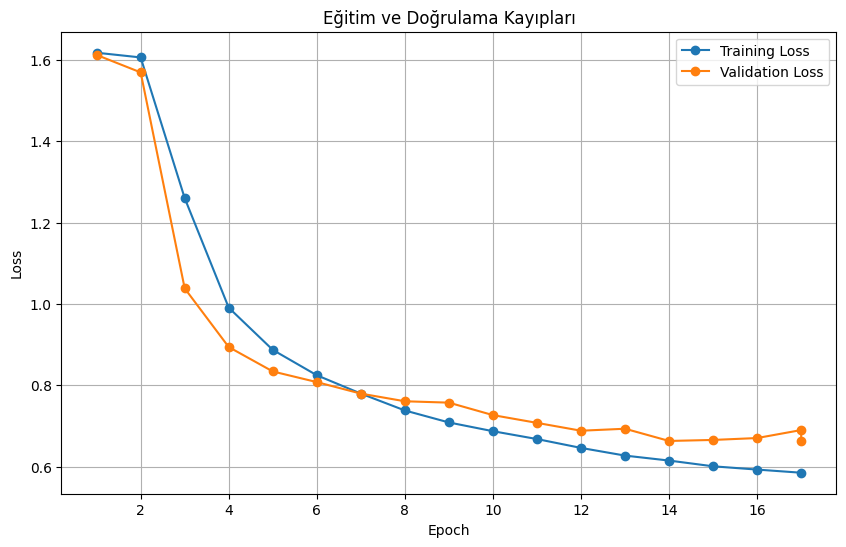

<Figure size 1000x800 with 0 Axes>

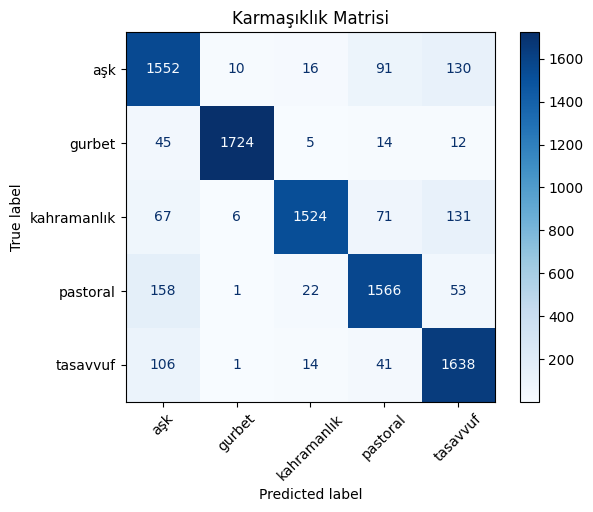

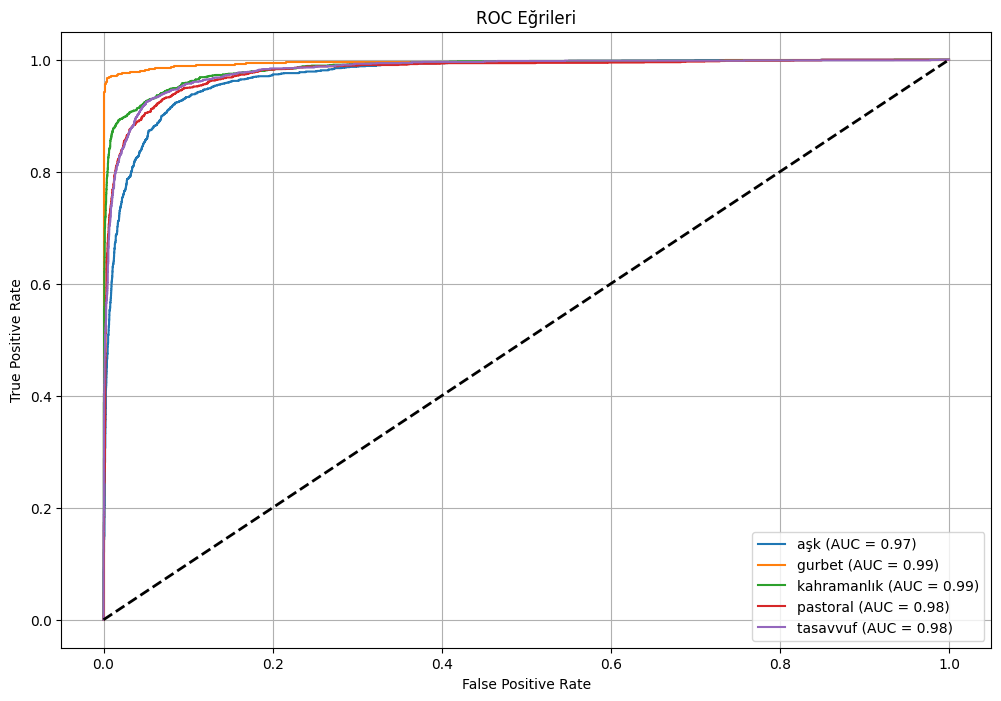

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

# ✅ Tokenizer ve Dataset
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["islenmis_siir"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()

    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list, sensitivity_list = [], []

    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate = 3e-6
dropout = 0.3
weight_decay = 0.1

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=weight_decay,
    label_smoothing_factor=0.1,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Mounted at /content/drive
🖥️ Kullanılan cihaz: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

✅ train_ds sütunları: ['label', 'input_ids', 'token_type_ids', 'attention_mask']
✅ val_ds sütunları: ['label', 'input_ids', 'token_type_ids', 'attention_mask']


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of CustomDeberta were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-927381389.py:222: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Sensitivity,Specificity,F1,Auc
1,1.740800,1.730730,0.242054,0.204697,0.242003,0.242003,0.810504,0.140726,0.536105
2,1.680700,1.719398,0.309624,0.457748,0.309651,0.309651,0.827416,0.265885,0.682235
3,1.269200,1.015309,0.657035,0.693087,0.656993,0.656993,0.914257,0.657469,0.885870
4,0.932700,0.773338,0.762392,0.769421,0.762392,0.762392,0.940599,0.765083,0.932432
5,0.761700,0.686191,0.789731,0.792361,0.789719,0.789719,0.947433,0.789477,0.948561
6,0.658300,0.627101,0.818515,0.823441,0.818508,0.818508,0.954629,0.820378,0.959006
7,0.597100,0.618043,0.827406,0.836627,0.827398,0.827398,0.956852,0.829116,0.965185
8,0.542100,0.545791,0.848188,0.853063,0.848186,0.848186,0.962048,0.849903,0.970589
9,0.503800,0.603043,0.844966,0.852534,0.844956,0.844956,0.961241,0.845315,0.971682
10,0.453100,0.527397,0.862858,0.867905,0.862845,0.862845,0.965714,0.863151,0.975537



📊 Değerlendirme Metrikleri:
eval_loss   : 0.3465
eval_accuracy: 0.9211
eval_precision: 0.9219
eval_recall : 0.9211
eval_sensitivity: 0.9211
eval_specificity: 0.9803
eval_f1     : 0.9213
eval_auc    : 0.9902
eval_runtime: 51.6984
eval_samples_per_second: 174.0480
eval_steps_per_second: 21.7610
epoch       : 25.0000

⏱️ Eğitim süresi: 16541.19 saniye

✅ Model ve etiket kodlayıcı kaydedildi: /content/drive/MyDrive/deberta_best_model


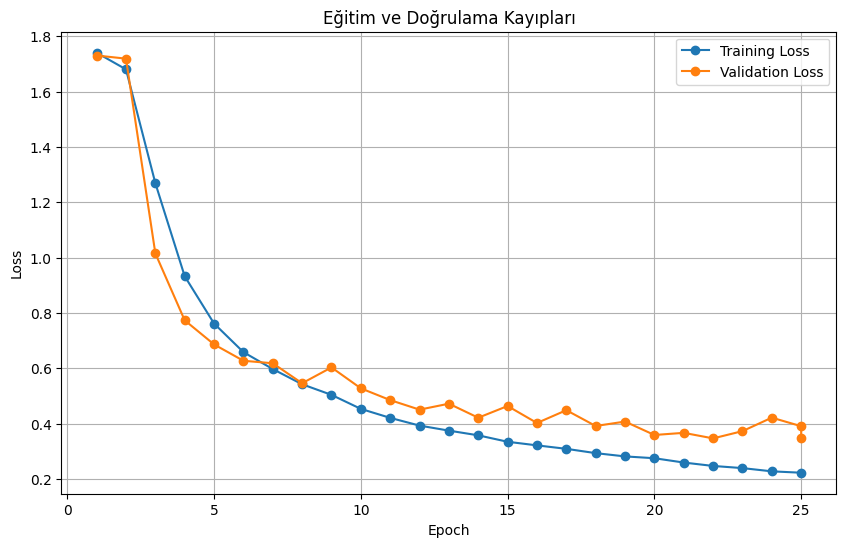

<Figure size 1000x800 with 0 Axes>

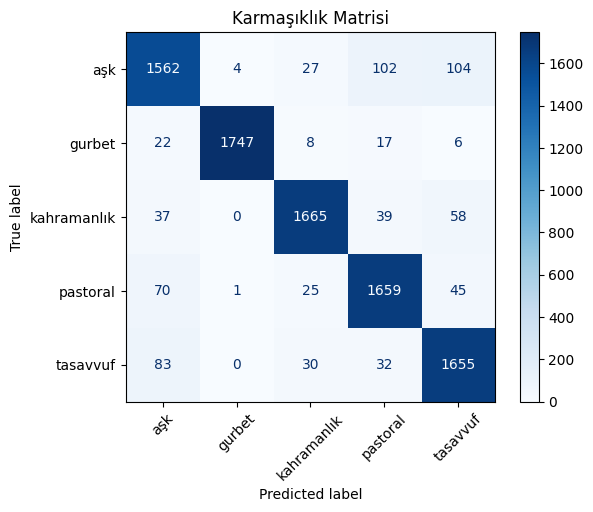

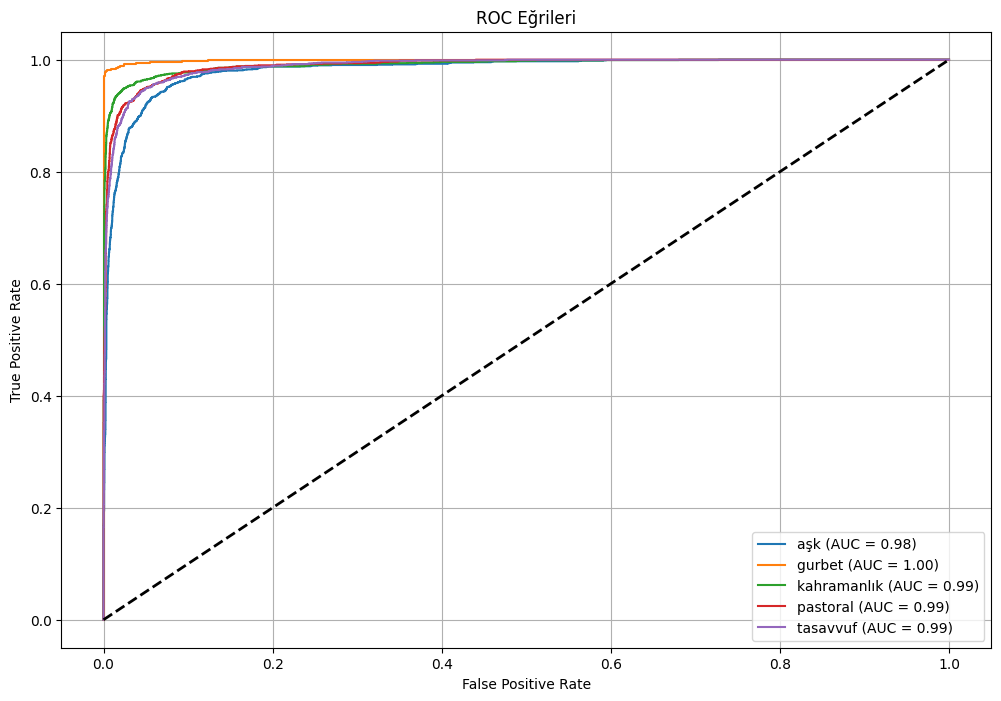

In [ ]:
# ✅ Ortam Ayarları
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kütüphaneler
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize

from datasets import Dataset
from transformers import (
    AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback,
    DataCollatorWithPadding, AutoConfig, DebertaForSequenceClassification
)

# ✅ Dosya Yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"
save_dir = "/content/drive/MyDrive/deberta_best_model"
os.makedirs(save_dir, exist_ok=True)

# ✅ Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Kullanılan cihaz:", device)

# ✅ Veriyi Yükle ve Etiketle
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Label encode işlemi
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

# ✅ JSON'dan oku
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# ✅ Etiketleri sayıya çevir
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["konu"])
val_df["label"] = label_encoder.transform(val_df["konu"])

# ✅ Sadece gerekli sütunları al
train_df = train_df[["islenmis_siir", "label"]]
val_df = val_df[["islenmis_siir", "label"]]

model_name = "microsoft/deberta-base"

# ✅ Tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# ✅ Tokenizasyon fonksiyonu (batched=True uyumlu)
def tokenize(batch):
    return tokenizer(
        batch["islenmis_siir"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

# ✅ Dataset'e çevir
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

# ✅ Tokenizer'ı uygula
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# ✅ Giriş verisini kaldır (artık input_ids oluşturuldu)
train_ds = train_ds.remove_columns("islenmis_siir")
val_ds = val_ds.remove_columns("islenmis_siir")

# ✅ Data collator (otomatik padding için)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ✅ Kontrol: Modelin beklediği sütunlar var mı?
print("✅ train_ds sütunları:", train_ds.column_names)
print("✅ val_ds sütunları:", val_ds.column_names)


# ✅ Confusion Penalty Loss
class ConfusionPenaltyLoss(nn.Module):
    def __init__(self, penalty_matrix=None, alpha=0.5):
        super(ConfusionPenaltyLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.penalty_matrix = penalty_matrix
        self.alpha = alpha

    def forward(self, logits, targets):
        ce_loss = self.cross_entropy(logits, targets)
        if self.penalty_matrix is not None:
            probs = F.softmax(logits, dim=1)
            penalty = 0.0
            for i in range(logits.size(0)):
                true_class = targets[i].item()
                for pred_class in range(probs.size(1)):
                    if pred_class != true_class:
                        penalty += self.penalty_matrix[true_class][pred_class] * probs[i][pred_class]
            penalty = penalty / logits.size(0)
            return ce_loss + self.alpha * penalty
        else:
            return ce_loss

class CustomDeberta(DebertaForSequenceClassification):
    def __init__(self, config, penalty_tensor=None, alpha=0.5):
        super().__init__(config)
        self.penalty_loss = ConfusionPenaltyLoss(penalty_matrix=penalty_tensor, alpha=alpha)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=False,
            output_attentions=False
        )
        logits = outputs.logits

        loss = None
        if labels is not None:
            loss = self.penalty_loss(logits, labels)

        return {"loss": loss, "logits": logits}


# ✅ Penalty Matrix
data_penalty = np.array([
    [0.0, 0.0, 0.1, 0.6, 1.0],
    [0.3, 0.0, 0.1, 0.1, 0.1],
    [0.4, 0.1, 0.0, 0.4, 0.7],
    [0.6, 0.1, 0.2, 0.0, 0.3],
    [0.8, 0.0, 0.3, 0.2, 0.0],
])
penalty_tensor = torch.tensor(data_penalty, dtype=torch.float32).to(device)

# ✅ Metrik Fonksiyonu
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    num_classes = len(np.unique(labels))
    specificity_list, sensitivity_list = [], []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        fn = cm[i, :].sum() - cm[i, i]
        tp = cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall": recall_score(labels, preds, average="macro", zero_division=0),
        "sensitivity": np.mean(sensitivity_list),
        "specificity": np.mean(specificity_list),
        "f1": f1_score(labels, preds, average="macro"),
        "auc": roc_auc_score(label_binarize(labels, classes=np.unique(labels)), probs, multi_class="ovo")
    }

# ✅ Model ve Eğitim Ayarları
learning_rate = 3e-6
dropout = 0.3
weight_decay = 0.1

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=dropout,
    attention_probs_dropout_prob=0.1
)

model = CustomDeberta.from_pretrained(
    model_name,
    config=config,
    penalty_tensor=penalty_tensor,
    alpha=0.5
).to(device)

training_args = TrainingArguments(
    output_dir=save_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=weight_decay,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    seed=42,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitimi Başlat
start_time = time.time()
trainer.train()
metrics = trainer.evaluate()

print("\n📊 Değerlendirme Metrikleri:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

print(f"\n⏱️ Eğitim süresi: {time.time() - start_time:.2f} saniye")

# ✅ Model ve Label Encoder Kaydet
trainer.save_model(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
print(f"\n✅ Model ve etiket kodlayıcı kaydedildi: {save_dir}")

# ✅ Eğitim ve Doğrulama Kayıpları Grafiği
log_history = trainer.state.log_history
train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []
for log in log_history:
    if "loss" in log and "epoch" in log:
        train_losses.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log and "epoch" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Karmaşıklık Matrisi
preds_output = trainer.predict(val_ds)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Karmaşıklık Matrisi")
plt.show()

# ✅ ROC Eğrileri
y_true = label_binarize(labels, classes=np.arange(len(label_encoder.classes_)))
y_score = torch.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
n_classes = y_true.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
